# Working with neuroimaging data in Python

We've already learned about general Python tools, but there is also a growing ecosystem of Python-based tools for working with neuroimaging data.

In this training, we will focus on `pybids`, `nibabel`, and `nilearn`.

In [29]:
%matplotlib inline
import os.path as op  # for navigating the system
from pprint import pprint  # for pretty-printing dictionaries
import numpy as np

dataset_folder = '/scratch/madlab/condassoc_bids/'

## PyBIDS
[PyBIDS](https://bids-standard.github.io/pybids/) is a package for **working with BIDS datasets**.

With PyBIDS, you can:
1. Validate datasets to make sure they're BIDS compliant.
2. Search datasets for specific files.
3. Read in metadata for files within datasets.
4. Generate citable reports summarizing datasets.
5. Apply transformations to variables in datasets for analysis.

In this training we will cover 1-3.

In [2]:
from bids import BIDSLayout, BIDSValidator

In [3]:
# Load in BIDS dataset as BIDSLayout object
layout = BIDSLayout(dataset_folder, validate=False)

In [4]:
# First let's look at the dataset description file to learn about the dataset
pprint(layout.get_dataset_description())

{'Authors': ['Adam Kimbler', 'Amanda G. Hamm', 'Aaron T. Mattfeld'],
 'BIDSVersion': '1.1.1',
 'DatasetDOI': '10.18112/openneuro.ds002078.v1.0.1',
 'License': 'CC0',
 'Name': 'Conditional Visual Associative Learning Task'}


In [5]:
# You can use the BIDSLayout object to search the data
# for different kinds of information
subjects = layout.get_subjects()
print('{} subjects in dataset'.format(len(subjects)))
print('Subject IDs: {}'.format(', '.join(subjects)))
print()

tasks = layout.get_tasks()
print('{} tasks in dataset'.format(len(tasks)))
print('Tasks: {}'.format(', '.join(tasks)))
print()

data_types = layout.get_datatypes()
print('{} data types in dataset'.format(len(data_types)))
print('Data types: {}'.format(', '.join(data_types)))

20 subjects in dataset
Subject IDs: 001, 002, 004, 005, 006, 007, 008, 009, 010, 012, 017, 018, 019, 020, 021, 022, 023, 024, 026, 027

1 tasks in dataset
Tasks: condassoc

2 data types in dataset
Data types: anat, func


In [6]:
# If you're confused about what you can search for,
# check the 'entities' attribute
# Each entity can be search with a "get_<entity>s" function
layout.entities

{'subject': <bids.layout.models.Entity at 0x7f98b09bbc88>,
 'session': <bids.layout.models.Entity at 0x7f98b0a35908>,
 'task': <bids.layout.models.Entity at 0x7f98b09bb940>,
 'acquisition': <bids.layout.models.Entity at 0x7f98b09abe48>,
 'contrast': <bids.layout.models.Entity at 0x7f98b09bb9b0>,
 'reconstruction': <bids.layout.models.Entity at 0x7f98b09bbb38>,
 'direction': <bids.layout.models.Entity at 0x7f98b09616d8>,
 'run': <bids.layout.models.Entity at 0x7f98b0961da0>,
 'proc': <bids.layout.models.Entity at 0x7f98b0961ef0>,
 'modality': <bids.layout.models.Entity at 0x7f98b0961be0>,
 'echo': <bids.layout.models.Entity at 0x7f98b097a710>,
 'recording': <bids.layout.models.Entity at 0x7f98b097aa20>,
 'suffix': <bids.layout.models.Entity at 0x7f98b097ad30>,
 'scans': <bids.layout.models.Entity at 0x7f98b097ada0>,
 'fmap': <bids.layout.models.Entity at 0x7f98b097add8>,
 'datatype': <bids.layout.models.Entity at 0x7f98b097a7b8>,
 'extension': <bids.layout.models.Entity at 0x7f98b097a74

In [7]:
# Each search function can take other entities as arguments
# For example, what TRs exist in the dataset?
print(layout.get_RepetitionTimes())

# Ah, but what about for functional scans only?
print(layout.get_RepetitionTimes(datatype='func'))

[0.009184, 2.0]
[2.0]


In [8]:
# There is also the general search method `get` that returns BIDS-type file object
sub_runs = layout.get(subject='001', task='condassoc', extension='nii.gz')
sub_runs

[<BIDSImageFile filename='/scratch/madlab/condassoc_bids/sub-001/func/sub-001_task-condassoc_run-01_bold.nii.gz'>,
 <BIDSImageFile filename='/scratch/madlab/condassoc_bids/sub-001/func/sub-001_task-condassoc_run-02_bold.nii.gz'>,
 <BIDSImageFile filename='/scratch/madlab/condassoc_bids/sub-001/func/sub-001_task-condassoc_run-03_bold.nii.gz'>,
 <BIDSImageFile filename='/scratch/madlab/condassoc_bids/sub-001/func/sub-001_task-condassoc_run-04_bold.nii.gz'>,
 <BIDSImageFile filename='/scratch/madlab/condassoc_bids/sub-001/func/sub-001_task-condassoc_run-05_bold.nii.gz'>,
 <BIDSImageFile filename='/scratch/madlab/condassoc_bids/sub-001/func/sub-001_task-condassoc_run-06_bold.nii.gz'>]

In [9]:
# Let's get the metadata for one of the functional scans
func_file = sub_runs[0].path
pprint(layout.get_metadata(func_file))

{'AcquisitionDateTime': '1800-01-01T16:10:15',
 'BodyPartExamined': 'BRAIN',
 'ConversionSoftware': 'dcm2nii',
 'ConversionSoftwareVersion': '6-2013',
 'EchoTime': 0.025,
 'FlipAngle': 75.0,
 'ImageType': 'ORIGINAL_PRIMARY_EPI_NONE',
 'MagneticFieldStrength': 3.0,
 'Manufacturer': 'GE MEDICAL SYSTEMS',
 'ProcedureStepDescription': 'Mattfeld_WMAZE',
 'ProtocolName': 'Mattfeld_WMAZE',
 'RepetitionTime': 2.0,
 'ScanningSequence': 'EP_GR',
 'SequenceVariant': 'S_S',
 'SliceTiming': [0.0,
                 1.0,
                 0.047619047619047616,
                 1.0476190476190477,
                 0.09523809523809523,
                 1.0952380952380953,
                 0.14285714285714285,
                 1.1428571428571428,
                 0.19047619047619047,
                 1.1904761904761905,
                 0.23809523809523808,
                 1.2380952380952381,
                 0.2857142857142857,
                 1.2857142857142858,
                 0.3333333333333333,
  

### Exercise 1
Load the dataset located in `/scratch/cis-training/ds001491` and print the name of the file with the **extension** `'nii.gz'` for **echo** `1` of the `'images'` **task** of **subject** `'01'`.

### Exercise 2
Use `BIDSLayout.get_metadata` to determine the EchoTime for that file.

## NiBabel
[NiBabel](https://nipy.org/nibabel/) allows you to **read and write neuroimaging files**.

In [10]:
import nibabel as nib

In [11]:
# Grab a random nifti file from the dataset
f = layout.get(extension='nii.gz', task='condassoc')[0].path
print(f)

/scratch/madlab/condassoc_bids/sub-001/func/sub-001_task-condassoc_run-01_bold.nii.gz


In [12]:
# Load the file as an image object
img = nib.load(f)
print(type(img))

<class 'nibabel.nifti1.Nifti1Image'>


In [27]:
# Each image has an affine matrix that contains information
# about the orientation and dimensionality of the data
print(img.affine)

[[-2.48171425e+00  5.10274842e-02  3.56942683e-01  1.11510391e+02]
 [-1.06421225e-01  2.15781951e+00 -1.50945055e+00 -5.21768532e+01]
 [ 2.82434911e-01  1.26143217e+00  2.56764340e+00 -1.02998154e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [13]:
# The image header contains a lot of its own information
hed = img.header
print(type(hed))

# get_zooms() prints the voxel sizes and
# repetition time (fourth dimension) for the image
hed.get_zooms()

<class 'nibabel.nifti1.Nifti1Header'>


(2.5, 2.5, 2.9997735, 2.0)

In [14]:
# The data are a 3D-to-4D array
data = img.get_data()
print(type(data))
print(data.shape)

<class 'numpy.ndarray'>
(96, 96, 42, 200)


In [30]:
# You can also create images from an affine matrix and a numpy array
random_data = np.random.random((96, 96, 42))
random_img = nib.Nifti1Image(random_data, img.affine)
print(type(random_img))

<class 'nibabel.nifti1.Nifti1Image'>


In [31]:
# You can also save image objects
random_img.to_filename('example_random_image.nii.gz')

### Exercise 1
Compute the mean of the data from the loaded functional scan and generate a new 3D image with the mean data.

## Nilearn
[Nilearn](http://nilearn.github.io) is primarily for doing machine learning on fMRI data, but it also provides a wide range of functionality, including:
- Applying masks to data
- Visualizing fMRI data
- Simple denoising and analysis
- Performing simple math on images

In [15]:
import nilearn as nl
from nilearn import masking

In [16]:
# Grab a random functional file from the dataset
f = layout.get(suffix='bold', extension='nii.gz')[0].path
print(f)
print(nib.load(f).shape)

/scratch/madlab/condassoc_bids/sub-001/func/sub-001_task-condassoc_run-01_bold.nii.gz
(96, 96, 42, 200)


In [41]:
# Generate a general brain mask from the functional data
mask = masking.compute_epi_mask(f)

In [48]:
# Apply the mask to the file
data = masking.apply_mask(f, mask)

print('Shape of the functional data: {}'.format(nib.load(f).shape))
print('Shape of the mask: {}'.format(mask.shape))
print('Number of voxels within mask: {}'.format(np.sum(mask.get_data())))
print('Shape of the masked data: {}'.format(data.shape))

Shape of the functional data: (96, 96, 42, 200)
Shape of the mask: (96, 96, 42)
Number of voxels within mask: 63276
Shape of the masked data: (200, 63276)


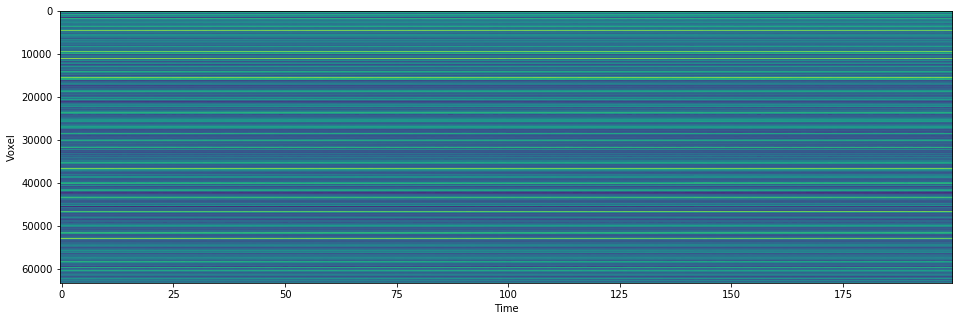

In [40]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16, 5))
ax.imshow(data.T, aspect='auto')
ax.set_xlabel('Time')
ax.set_ylabel('Voxel')
fig.show()

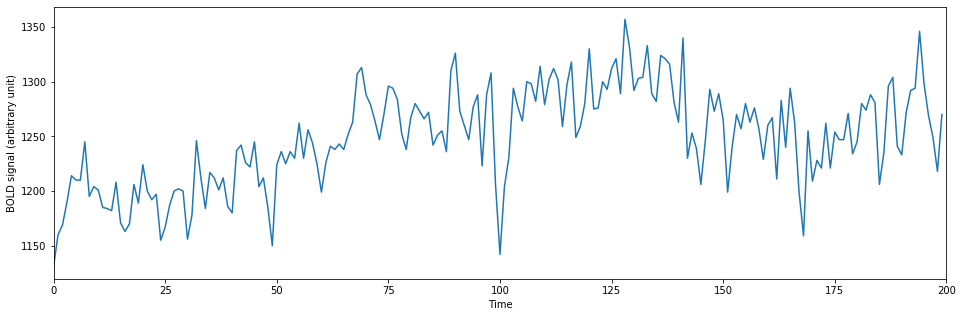

In [39]:
# Let's plot one voxel's time series
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(data[:, 0])
ax.set_xlabel('Time')
ax.set_ylabel('BOLD signal (arbitrary unit)')
ax.set_xlim(0, data.shape[0])
fig.show()

In [32]:
from nilearn import image

In [21]:
first_volume = image.index_img(f, 0)
print(first_volume.shape)

(96, 96, 42)


In [22]:
# Katie Bottenhorn already walked you through nilearn's plotting tools,
# so we'll just use them briefly here
from nilearn import plotting

/home/data/cis/training-week-2019/env/lib/python3.6/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


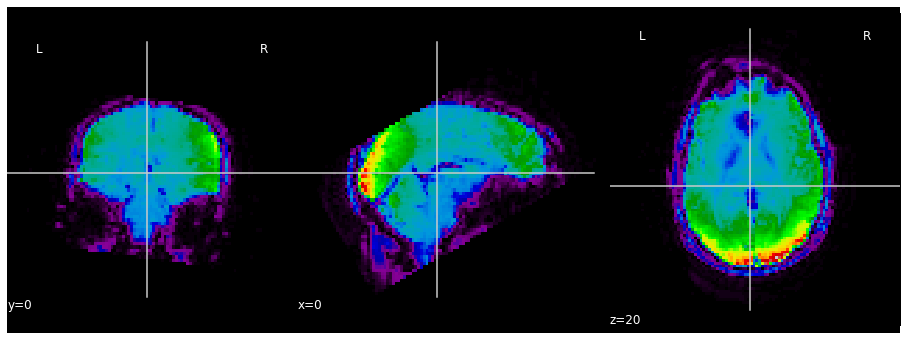

In [23]:
# Plot the first volume of the functional data
fig, ax = plt.subplots(figsize=(16, 6))
plotting.plot_epi(first_volume, axes=ax, cut_coords=[0, 0, 20])
fig.show()

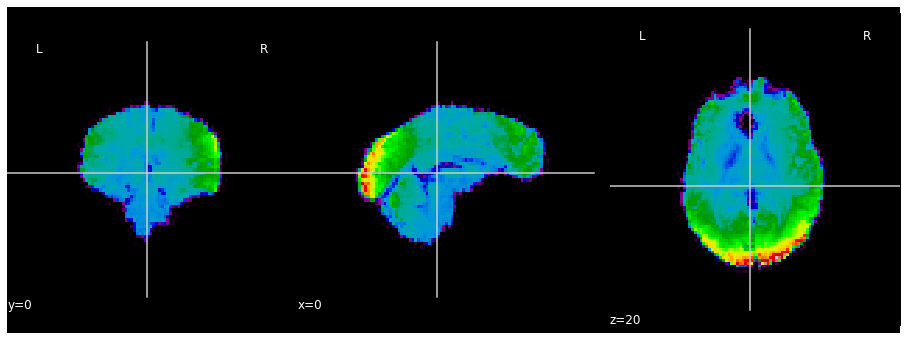

In [24]:
# Plot the masked first volume of the functional data
masked_first_volume = masking.unmask(masking.apply_mask(first_volume, mask), mask)
fig, ax = plt.subplots(figsize=(16, 6))
plotting.plot_epi(masked_first_volume, axes=ax, cut_coords=[0, 0, 20])
fig.show()